100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


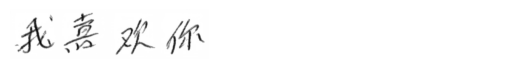

In [17]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils.dataset import CharacterDataset
from utils.function import plot_sample
from model.generator import SynthesisGenerator
from torchvision import transforms
from utils.function import SquarePad, ColorReverse
import sys
import pickle
from tqdm import tqdm
import random
import numpy as np
import cv2

batch_size = 1
reference_count = 4
path = './dataset'
pretrain = '/home/bujiazi/workspace/metascript/checkpoint/training_20231211103807/iteration_80000/generator.pth'
generator = SynthesisGenerator(reference_count=reference_count)
generator.load_state_dict(torch.load(pretrain, map_location='cpu'))
generator.eval()

def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def get_template(string):
    with open("./alphabet_3755.pkl", 'rb') as file:
        dic = pickle.load(file)
    idxs = []
    for i in range(len(string)):
        idx = find_key_by_value(dic, string[i])
        idxs.append(idx)
    string_pngs = load_images_from_folder("./dataset/template", idxs)
    return string_pngs

def find_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None

def load_images_from_folder(folder_path, image_names):
    loaded_images = []
    
    for image_name in image_names:
        image_path = os.path.join(folder_path, f"{image_name}.png")
        
        if os.path.exists(image_path):
            image = Image.open(image_path)
            loaded_images.append(image)
        else:
            print(f"Image {image_name}.png not found in folder {folder_path}")
            loaded_images.append(None)  

    return loaded_images

def random_files_from_directory(directory_path, num_files=4):
    files_list = os.listdir(directory_path)
    selected_files = random.sample(files_list, min(num_files, len(files_list)))
    return [os.path.join(directory_path, file) for file in selected_files]

def display_images(image_list, cols):

    max_width = max(image.width for image in image_list)
    max_height = max(image.height for image in image_list)

   
    total_rows = len(image_list) // cols + (len(image_list) % cols > 0)

    big_image = Image.new('RGBA', (cols * max_width, total_rows * max_height), (255, 255, 255, 0))

    for i in range(total_rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(image_list) and image_list[index] is not None:
                image = image_list[index].convert('RGBA')
                big_image.paste(image, (j * max_width, i * max_height), mask=image)

    plt.imshow(big_image)
    plt.axis('off') 
    plt.show()

def gen_string(template_string, writer):
    
    normalize = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            ColorReverse(),
            SquarePad(),
            transforms.Resize((128, 128), antialias=True),
            transforms.Normalize((0.5,), (0.5,))
        ])
    reverse = ColorReverse()
    
    string_tensors = []
    
    for img in template_string:
        img_t = normalize(img)
        img_t = img_t.unsqueeze(0)
        string_tensors.append(img_t)
        
    res = []
    
    path = f"./dataset/script/{writer+1000}-c/"
    
    ref_list = [Image.open(img_path) for img_path in random_files_from_directory(path, 4)]

    ref_tensors = []

    for ref_img in ref_list:
        ref_t = normalize(ref_img)
        ref_t = ref_t.unsqueeze(0)
        ref_tensors.append(ref_t)

    ref = torch.cat(ref_tensors, dim=1)

    for img_t in tqdm(string_tensors):
        result, structure, style = generator(ref, img_t)
        result = result.squeeze(0).squeeze(0)
        res.append(result)
        
    res = [reverse(img) for img in res]

    res = [img.detach().cpu().numpy()*255 for img in res]
    
    res = [Image.fromarray(img.astype('uint8'), mode='L') for img in res]
    
    return res
    
set_all_seeds(0)

string = input("请输入一个字符串：")

writer = int(input("请输入一个作者："))

assert 1 <= writer <= 300, "作者越界，请确保作者值在1到300的闭区间内"

# 生成标准字体模板的字符串
template_string = get_template(string)

# 生成指定作者风格的字符串
res = gen_string(template_string, writer)
# 控制每一行有多少个字

cols = 10

# 展示字符串
display_images(res,  cols)


# prob = 0.5


# def random_offset(image, max_offset):
#     offset_x = np.random.randint(-max_offset, max_offset + 1)
#     offset_y = np.random.randint(-max_offset, max_offset + 1)

   
#     height, width = image.shape[:2]

#     matrix = np.array([[1, 0, offset_x], [0, 1, offset_y]], dtype=np.float32)

#     offset_image = cv2.warpAffine(image, matrix, (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

#     return offset_image
    

# for img in tqdm(res):
#     if np.random.rand() < prob:
#         kernel = np.ones((10, 10), np.uint8)
#         img = cv2.dilate(img, kernel, iterations = 1)   
#     if np.random.rand() < prob:
#         img = random_offset(img, 100)






